In [1]:
# Import statements 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
# Load the cleaned dataset
df = pd.read_csv("../data/cleaned/air_traffic_clean.csv")

# Verify
df.head()


,Month,AustralianPort,ForeignPort,Country,Passengers_In,Freight_In_(tonnes),Mail_In_(tonnes),Passengers_Out,Freight_Out_(tonnes),Mail_Out_(tonnes),Passengers_Total,Freight_Total_(tonnes),Mail_Total_(tonnes),Year,Month_num,Route,Date
0,Jan-85,Adelaide,Auckland,New Zealand,1513,42.167,0.311,985,18.704,0.924,2498,60.871,1.235,1985,1,Adelaide to Auckland,1985-01-01
1,Jan-85,Adelaide,Bahrain,Bahrain,12,0.000,0.000,5,0.033,0.000,17,0.033,0.000,1985,1,Adelaide to Bahrain,1985-01-01
2,Jan-85,Adelaide,Bombay,India,7,0.000,0.000,5,0.000,0.000,12,0.000,0.000,1985,1,Adelaide to Bombay,1985-01-01
3,Jan-85,Adelaide,Frankfurt,Germany,115,0.009,0.000,171,0.000,0.248,286,0.009,0.248,1985,1,Adelaide to Frankfurt,1985-01-01
4,Jan-85,Adelaide,London,UK,1567,2.800,0.000,1472,10.618,2.487,3039,13.418,2.487,1985,1,Adelaide to London,1985-01-01


In [3]:
# Make a subset of the data for one specific route
df_model = df[(df['AustralianPort'] == 'Sydney') & (df['ForeignPort'] == 'Singapore')]
df_model.head() 
 

,Month,AustralianPort,ForeignPort,Country,Passengers_In,Freight_In_(tonnes),Mail_In_(tonnes),Passengers_Out,Freight_Out_(tonnes),Mail_Out_(tonnes),Passengers_Total,Freight_Total_(tonnes),Mail_Total_(tonnes),Year,Month_num,Route,Date
151,Jan-85,Sydney,Singapore,Singapore,13422,288.891,6.384,10477,576.498,4.326,23899,865.389,10.710,1985,1,Sydney to Singapore,1985-01-01
309,Feb-85,Sydney,Singapore,Singapore,12499,331.308,5.713,9035,675.514,5.127,21534,1006.822,10.840,1985,2,Sydney to Singapore,1985-02-01
465,Mar-85,Sydney,Singapore,Singapore,10731,422.649,6.940,12098,957.478,5.709,22829,1380.127,12.649,1985,3,Sydney to Singapore,1985-03-01
630,Apr-85,Sydney,Singapore,Singapore,8649,353.841,7.154,12397,668.141,5.418,21046,1021.982,12.572,1985,4,Sydney to Singapore,1985-04-01
786,May-85,Sydney,Singapore,Singapore,10466,376.336,6.205,12392,619.906,6.807,22858,996.242,13.012,1985,5,Sydney to Singapore,1985-05-01


In [4]:
df_model = df_model.copy()

# make sure sorted by date
df_model = df_model.sort_values('Date').reset_index(drop=True)

# features
y = df_model['Passengers_Total'].astype(float).values

In [5]:
# Sort and make a clean, consecutive time index
df_model = df_model.sort_values('Date').reset_index(drop=True)
if 'time_idx' not in df_model.columns:
    df_model['time_idx'] = np.arange(len(df_model))


In [6]:
# Month dummy variables so that model is able to see seasonality 
MONTH_CATS = list(range(1, 13)) 
month_cat = pd.Categorical(df_model['Month_num'], categories=MONTH_CATS, ordered=True)
month_dummies = pd.get_dummies(month_cat, prefix='m', drop_first=True)
 

In [7]:
# Polynomial trend (degree=3 works well)
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(df_model[['time_idx']])

# Combine features
X_full = np.hstack([X_poly, month_dummies.values])

In [8]:
# Fit ridge regression
ridge = Ridge(alpha=.1)  
ridge.fit(X_full, y)

df_model['fit_monthly'] = ridge.predict(X_full)


In [9]:
# Forecast next 12 months 
# Make sure Date is datetime (not a string)
df_model['Date'] = pd.to_datetime(df_model['Date'], errors='coerce')
df_model = df_model.dropna(subset=['Date'])   

# Get the last date and the future dates(next 12 months)
last_date = df_model['Date'].iloc[-1]      
future_dates = pd.date_range(start=last_date, periods=13, freq="MS")[1:]

# Match the future index values
future_idx = np.arange(df_model['time_idx'].iloc[-1] + 1,
                       df_model['time_idx'].iloc[-1] + 13)

# Month dummies for future months
future_months = pd.Categorical(future_dates.month, categories=MONTH_CATS, ordered=True)
future_dummies = pd.get_dummies(future_months, prefix='m', drop_first=True).reindex(
    columns=month_dummies.columns, fill_value=0
)

# Polynomial trend for future
X_future_poly = poly.transform(future_idx.reshape(-1, 1))
X_future = np.hstack([X_future_poly, future_dummies.values])

future_preds = ridge.predict(X_future)
forecast_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_preds})

/Users/diyakadakia/anaconda3/envs/new-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


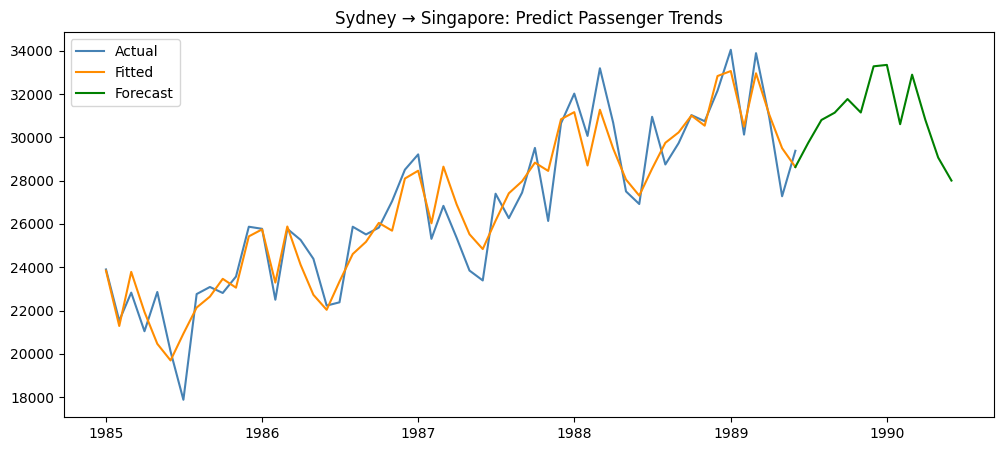

In [10]:
# Make forecast data a DataFrame
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecast': future_preds})

# Append the last fitted point so forecast connects smoothly
last_point = pd.DataFrame({
    'Date': [df_model['Date'].iloc[-1]],
    'Forecast': [df_model['fit_monthly'].iloc[-1]]})

# Combine the DateFrames  
forecast_df = pd.concat([last_point, forecast_df], ignore_index=True)

# Plot 
plt.figure(figsize=(12,5))
plt.plot(df_model['Date'], df_model['Passengers_Total'], color='steelblue', label='Actual')
plt.plot(df_model['Date'], df_model['fit_monthly'], color='darkorange', label='Fitted')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], color='green', label='Forecast')
plt.title("Sydney → Singapore: Predict Passenger Trends")
plt.legend()
plt.show()


In [13]:
# Evaluate
y_true = df_model['Passengers_Total']
y_pred = df_model['fit_monthly']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 919.49
RMSE: 1151.84
MAPE: 3.57%
